# Brain tumor classification

## Set up

In [1]:
import os
import PIL
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Verification of the folder (expected train test val)
!ls '/content/drive/My Drive/Colab Notebooks/dataset_gestion_couleur'

test  train  val


In [5]:
drive_path = "/content/drive/My Drive/Colab Notebooks/dataset_gestion_couleur"
local_path = "/content/dataset_local"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
from torchvision.models import resnet50, ResNet50_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter

if not os.path.exists(local_path):
    print("Copy the dataset to the local VM to speed up access...")
    shutil.copytree(drive_path, local_path)
    print("Copy finished.")

Copy the dataset to the local VM to speed up access...
Copy finished.


## Resnet50: full transfer learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
from torchvision.models import resnet50, ResNet50_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter

# Copy on local of the dataset
if not os.path.exists(local_path):
    print("Copy the dataset to the local VM to speed up access...")
    shutil.copytree(drive_path, local_path)
    print("Copy finished.")


# Initialisation of wandb
config = {
    "batch_size_physical": 32,
    "lr": 1e-4,
    "epochs": 60,
    "architecture": "ResNet50",
    "strategy": "Transfer Learning",
    "augmentation": "HorizontalFlip + Rotation"
}

wandb.login(key="API_KEY")
wandb.init(project="brain_tumor_classification", name="resnet50", config=config)


# 2. Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}


# 3. Datasets & DataLoaders
batch_size =  config['batch_size_physical']
num_workers = 2

image_datasets = {x: datasets.ImageFolder(os.path.join(local_path, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True if x=='train' else False,
                             num_workers=num_workers, pin_memory=True)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
classes = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Classes : {classes}")
print(f"Device : {device}")

# Calculating weights for unbalanced classes
print("Calcul des poids de classes...")
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(len(classes))]
total_count = sum(class_count)
weights = [total_count / (len(classes) * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)
print(f"Poids appliqués aux classes : {weights}")


# Load ResNet50 pretrained
weights = ResNet50_Weights.DEFAULT
model_ft = resnet50(weights=weights)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_ft.fc.parameters(), lr=1e-4)


# Training loop
num_epochs = config['epochs']
patience = 10
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*20)

    for phase in ['train','val']:
        if phase=='train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        loop = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}", leave=False)

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=='train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

            loop.set_postfix(loss=running_loss/((loop.n+1)*batch_size),
                             acc=(running_corrects.double()/((loop.n+1)*batch_size)).item())

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Log metrics on wandb
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1})

        # Best model
        if phase=='val':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                epochs_no_improve = 0
                torch.save(model_ft.state_dict(), "best_resnet50_transfer_learning.pth")
                wandb.save("best_resnet50_transfer_learning.pth")
            else:
                epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), "best_resnet50_transfer_learning.pth")
wandb.save("best_resnet50_transfer_learning.pth")

print("Model saved : best_resnet50_transfer_learning.pth")


### Evaluation

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import os


# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="resnet50_transfert_learning_evaluation",
    job_type="evaluation"
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)


# Load the trained model
model_path = "best_resnet50_transfer_learning.pth"
assert os.path.exists(model_path), "Model not found!"

model_ft = resnet50(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc =nn.Linear(num_ftrs, 4)

model_ft.load_state_dict(torch.load(model_path, map_location=device))
model_ft = model_ft.to(device)
model_ft.eval()


# Test Dataset & DataLoader
test_dir = "/content/dataset_local/test"

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

classes = test_dataset.classes
print("Classes:", classes)
print("Number of test images:", len(test_dataset))


# 5. Evaluation loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

# ROC-AUC multiclass
y_true_bin = label_binarize(all_labels, classes=[0,1,2,3])
roc_auc_macro = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")

print("\n=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")

# W&B logging
wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})


# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })


# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Confusion Matrix - Test set")
plt.tight_layout()
plt.show()

# Save model as Artifact
artifact = wandb.Artifact(
    name="resnet50",
    type="model",
    description="ResNet50 evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()
print("\nEvaluation completed and logged to W&B")


## Resnet 50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
from torchvision.models import resnet50, ResNet50_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter

if not os.path.exists(local_path):
    print("Copy the dataset to the local VM to speed up access...")
    shutil.copytree(drive_path, local_path)
    print("Copy finished.")

# Intialisation of wandb
config = {
    "batch_size_physical": 32,
    "lr": 1e-4,
    "epochs": 60,
    "architecture": "ResNet50",
    "strategy": "Fine-Tuning (Layer 4 + FC)",
    "augmentation": "Rotation"
}

wandb.login(key="API_KEY")
wandb.init(project="brain_tumor_classification", name="resnet50", config=config)


# Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}


# Datasets & DataLoaders
batch_size = config['batch_size_physical']
num_workers = 2

image_datasets = {x: datasets.ImageFolder(os.path.join(local_path, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True if x=='train' else False,
                             num_workers=num_workers, pin_memory=True)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
classes = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Classes : {classes}")
print(f"Device : {device}")

# Calculation of weights for unbalanced classes
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(len(classes))]
total_count = sum(class_count)
weights = [total_count / (len(classes) * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)
print(f"Weights: {weights}")


# Load pretrained ResNet50
weights = ResNet50_Weights.DEFAULT
model_ft = resnet50(weights=weights)

for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.layer4.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
params_to_update = [p for p in model_ft.parameters() if p.requires_grad]

# Adam optimizer with weight decay to improve regularization
optimizer = optim.Adam(params_to_update, lr=config['lr'], weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5
)

# Training loop
num_epochs = config['epochs']
patience = 5
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*20)

    for phase in ['train','val']:
        if phase=='train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        loop = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}", leave=False)

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=='train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

            loop.set_postfix(loss=running_loss/((loop.n+1)*batch_size),
                             acc=(running_corrects.double()/((loop.n+1)*batch_size)).item())

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Log metrics sur wandb
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1})

        # Best model
        if phase=='val':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                epochs_no_improve = 0
                torch.save(model_ft.state_dict(), "best_resnet50.pth")
                wandb.save("best_resnet50.pth")
            else:
                epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), "best_resnet50.pth")
wandb.save("best_restnet50.pth")
print("Model saved : best_restnet50.pth")


### Evaluation

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import os

# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="resnet50_evaluation",
    job_type="evaluation"
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)


# Load the trained model
model_path = "best_resnet50.pth"
assert os.path.exists(model_path), "Model not found!"

model_ft = resnet50(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft.load_state_dict(torch.load(model_path, map_location=device))
model_ft = model_ft.to(device)
model_ft.eval()

# Test Dataset & DataLoader
test_dir = "/content/dataset_local/test"

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

classes = test_dataset.classes
print("Classes:", classes)
print("Number of test images:", len(test_dataset))

# Evaluation loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

# ROC-AUC multiclass
y_true_bin = label_binarize(all_labels, classes=[0,1,2,3])
roc_auc_macro = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")

print("\n=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")

# W&B logging
wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})

# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })

# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Confusion Matrix - Test set")
plt.tight_layout()
plt.show()

# Save model as Artifact
artifact = wandb.Artifact(
    name="resnet50",
    type="model",
    description="ResNet50 evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()
print("\nEvaluation completed and logged to W&B")


## VGG16

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
import numpy as np
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter

if not os.path.exists(local_path):
    print("Copying the dataset to the local VM...")
    shutil.copytree(drive_path, local_path)
    print("Copy finished.")

# Configuration
physical_batch_size = 16
accumulation_steps = 2

config = {
    "batch_size_physical": physical_batch_size,
    "batch_size_effective": physical_batch_size * accumulation_steps,
    "lr": 1e-4,
    "epochs": 60,
    "architecture": "VGG16_BN",
    "strategy": "Fine-Tuning (Full Classifier) + Grad Accumulation",
    "augmentation": "HorizontalFlip+Rotation"
}

wandb.login()
wandb.init(project="brain_tumor_classification", name="vgg16", config=config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Datasets & Dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(local_path, x), transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=physical_batch_size,
                             shuffle=True if x=='train' else False,
                             num_workers=2, pin_memory=True)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
classes = image_datasets['train'].classes

# Unbalanced weights
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(len(classes))]
total_count = sum(class_count)
weights = [total_count / (len(classes) * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)
print(f"Weights : {weights}")


# VGG16 model
weights_model = VGG16_BN_Weights.DEFAULT
model_ft = vgg16_bn(weights=weights_model)

# Freeze Features
for param in model_ft.features.parameters():
    param.requires_grad = False

# Unfreeze Classifier
for param in model_ft.classifier.parameters():
    param.requires_grad = True

# Custom Head
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_ft.parameters(), lr=config['lr'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


# Training loop
num_epochs = config['epochs']
patience = 5
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*20)

    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({"lr": current_lr, "epoch": epoch+1})

    for phase in ['train','val']:
        if phase=='train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        optimizer.zero_grad()

        loop = tqdm(dataloaders[phase], desc=f"{phase} Ep {epoch+1}", leave=False)

        for i, (inputs, labels) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(phase=='train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss = loss / accumulation_steps
                    loss.backward()

                    if (i + 1) % accumulation_steps == 0:
                        optimizer.step()
                        optimizer.zero_grad()

            batch_loss = loss.item() * accumulation_steps if phase == 'train' else loss.item()

            running_loss += batch_loss * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

            loop.set_postfix(loss=batch_loss, acc=(torch.sum(preds==labels.data).double()/inputs.size(0)).item())

        if phase == 'train' and len(dataloaders['train']) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1})

        if phase=='val':
            scheduler.step(epoch_loss)

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                epochs_no_improve = 0
                torch.save(model_ft.state_dict(), "best_vgg16.pth")
                wandb.save("best_vgg16.pth")
                print(f"--> New best (Acc: {best_acc:.4f})")
            else:
                epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), "final_vgg16.pth")
wandb.save("final_vgg16.pth")
wandb.finish()

### Evaluation

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import vgg16_bn, VGG16_BN_Weights

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="vgg16_evaluation",
    job_type="evaluation"
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

# Load trained model
model_path = "best_vgg16.pth"
assert os.path.exists(model_path), "Model not found!"

weights_model = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights=None)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 4)

model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Test Dataset & DataLoader
test_dir = "/content/dataset_local/test"

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

classes = test_dataset.classes
print("Classes:", classes)
print("Number of test images:", len(test_dataset))


# Evaluation loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

# ROC-AUC multi-class
y_true_bin = label_binarize(all_labels, classes=list(range(len(classes))))
roc_auc_macro = roc_auc_score(
    y_true_bin,
    all_probs,
    average="macro",
    multi_class="ovr"
)

print("\n=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")

wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})

# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })

# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix – Test set")
plt.tight_layout()
plt.show()


# Save model as Artifact
artifact = wandb.Artifact(
    name="vgg16_bn",
    type="model",
    description="VGG16_BN evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()
print("\nEvaluation completed and logged to W&B")


## DenseNet121

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter


if not os.path.exists(local_path):
    print("Copying the dataset to the local VM...")
    shutil.copytree(drive_path, local_path)
    print("Copy finished.")
-

PHYSICAL_BATCH_SIZE = 32
ACCUMULATION_STEPS = 4  # Batch effectif = 128

config = {
    "batch_size_physical": PHYSICAL_BATCH_SIZE,
    "batch_size_effective": PHYSICAL_BATCH_SIZE * ACCUMULATION_STEPS,
    "lr": 1e-4,
    "epochs": 60,
    "patience": 10,
    "architecture": "DenseNet121",
    "strategy": "Fine-Tuning (DenseBlock4 + Norm5 + Classifier)",
    "augmentation": "HFlip + Rotation(10)"
}

wandb.login()
wandb.init(project="brain_tumor_classification", name="densenet121", config=config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Datasets & Dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(local_path, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=PHYSICAL_BATCH_SIZE,
                             shuffle=True if x=='train' else False,
                             num_workers=2, pin_memory=True)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
classes = image_datasets['train'].classes

# Computation of the weights for each classes
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(len(classes))]
total_count = sum(class_count)
weights = [total_count / (len(classes) * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)

# Load pretrained DenseNet121
weights_model = DenseNet121_Weights.DEFAULT
model_ft = densenet121(weights=weights_model)

for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.features.denseblock4.parameters():
    param.requires_grad = True

for param in model_ft.features.norm5.parameters():
    param.requires_grad = True

num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
params_to_update = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=config['lr'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

# Training loop
num_epochs = config['epochs']
patience = config['patience']
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*20)

    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({"lr": current_lr, "epoch": epoch+1})

    for phase in ['train','val']:
        if phase=='train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        optimizer.zero_grad()

        loop = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}", leave=False)

        for i, (inputs, labels) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(phase=='train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss = loss / ACCUMULATION_STEPS
                    loss.backward()

                    if (i + 1) % ACCUMULATION_STEPS == 0:
                        optimizer.step()
                        optimizer.zero_grad()

            # Logging correct loss value
            current_loss_val = loss.item() * ACCUMULATION_STEPS if phase == 'train' else loss.item()

            running_loss += current_loss_val * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

            loop.set_postfix(loss=current_loss_val, acc=(running_corrects.double()/((loop.n+1)*PHYSICAL_BATCH_SIZE)).item())

        if phase == 'train' and len(dataloaders['train']) % ACCUMULATION_STEPS != 0:
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1})

        if phase=='val':
            scheduler.step(epoch_loss)

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                epochs_no_improve = 0
                torch.save(model_ft.state_dict(), "best_densenet121.pth")
                wandb.save("best_densenet121.pth")
                print(f"--> New best ! (Acc: {best_acc:.4f})")
            else:
                epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), "final_densenet121.pth")
wandb.save("final_densenet121.pth")
wandb.finish()

### Evaluation

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import densenet121, DenseNet121_Weights

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import numpy as np
import shutil


# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="densenet121_evaluation",
    job_type="evaluation"
)


# Device & Dataset Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)


# Load Trained Model (DenseNet121)
model_path = "best_densenet121.pth"

weights_model = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights_model)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 4)

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except RuntimeError as e:
    print("Error in loading")
    raise e

model = model.to(device)
model.eval()

# Test Dataset & DataLoader
test_dir = os.path.join(local_path, "test")

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

classes = test_dataset.classes
print(f"Classes found : {classes}")
print(f"Nombre test images : {len(test_dataset)}")


# Evaluation Loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

# ROC-AUC multi-class
y_true_bin = label_binarize(all_labels, classes=list(range(len(classes))))
try:
    roc_auc_macro = roc_auc_score(
        y_true_bin,
        all_probs,
        average="macro",
        multi_class="ovr"
    )
except ValueError:
    roc_auc_macro = 0.0

print("\n" + "="*30)
print("=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")
print("="*30)

wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})

# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })


# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title(f"Confusion Matrix - Test set")
plt.tight_layout()
plt.savefig("densenet121_confusion_matrix.png", dpi=300)
plt.show()


# Save Model as Artifact
artifact = wandb.Artifact(
    name="densenet121",
    type="model",
    description="DenseNet121 evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()

## Inception

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
from torchvision.models import inception_v3, Inception_V3_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter

if not os.path.exists(local_path):
    print(f"Copying dataset from {drive_path} to {local_path}...")
    try:
        shutil.copytree(drive_path, local_path)
        print("Copy finished.")
    except Exception as e:
        print(f"Error copying dataset: {e}")
else:
    print("Dataset already exists locally.")

# Configuration
config = {
    "batch_size_physical": 32,
    "lr": 1e-4,
    "epochs": 60,
    "architecture": "InceptionV3",
    "strategy": "Fine-Tuning (Mixed_7c + AuxLogits + FC)",
    "augmentation": "Rotation + Resize 299 + ImageNet Norm"
}

wandb.login(key="API_KEY")
wandb.init(project="brain_tumor_classification", name="inception_v3_optimized", config=config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Transformations
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
}

# Datasets & DataLoaders
batch_size = config['batch_size_physical']

image_datasets = {
    x: datasets.ImageFolder(os.path.join(local_path, x), transform=data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size,
                  shuffle=(x == 'train'), num_workers=2, pin_memory=True)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = image_datasets['train'].classes
num_classes = len(classes)

print(f"Classes: {classes}")
print(f"Dataset sizes: {dataset_sizes}")

# Class Weights Calculation
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(num_classes)]
weights = [sum(class_count) / (num_classes * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)
print(f"Class Weights: {weights}")

# Loading Inception V3
weights_inception = Inception_V3_Weights.DEFAULT
model_ft = inception_v3(weights=weights_inception)

for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.Mixed_7c.parameters():
    param.requires_grad = True

for param in model_ft.AuxLogits.parameters():
    param.requires_grad = True

for param in model_ft.fc.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

num_aux_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_aux_ftrs, num_classes)
model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)
params_to_update = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=config['lr'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5
)


# Training Loop
num_epochs = config["epochs"]
patience = 7
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

print("\nStarting Training...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        loop = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}", leave=False)

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    outputs, aux_outputs = model_ft(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                else:
                    outputs = model_ft(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            loop.set_postfix(
                loss=running_loss/((loop.n+1)*batch_size),
                acc=(running_corrects.double()/((loop.n+1)*batch_size)).item()
            )

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1})

        if phase == 'val':
            scheduler.step(epoch_loss)

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                epochs_no_improve = 0

                # Save checkpoint
                torch.save(model_ft.state_dict(), "best_inception_v3.pth")
                wandb.save("best_inception_v3.pth")
                print(f"--> New best Acc: {best_acc:.4f} (Saved)")
            else:
                epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break


model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), "final_inception_v3.pth")
wandb.save("final_inception_v3.pth")
wandb.finish()

### Evaluation

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3, Inception_V3_Weights

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import numpy as np
import shutil

# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="inception_v3_evaluation",
    job_type="evaluation"
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

if not os.path.exists(local_path):
    if os.path.exists(drive_path):
        print("Dataset not found locally. Copying from Drive...")
        shutil.copytree(drive_path, local_path)
        print("Copy completed.")
    else:
        print("Warning: Dataset not found on Drive either.")


# 3. Load Trained Model (Inception V3)
model_path = "best_inception_v3.pth"
weights_model = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=None)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

num_aux_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_aux_ftrs, 4)

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Weights loaded successfully.")
except RuntimeError as e:
    print("Dimension error. Ensure you redefined AuxLogits correctly.")
    raise e

model = model.to(device)
model.eval()

# Test Dataset & DataLoader
test_dir = os.path.join(local_path, "test")
test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std =[0.5, 0.5, 0.5]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

classes = test_dataset.classes
print(f"Classes found: {classes}")
print(f"Number of test images: {len(test_dataset)}")

# Evaluation loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

y_true_bin = label_binarize(all_labels, classes=list(range(len(classes))))
try:
    roc_auc_macro = roc_auc_score(
        y_true_bin,
        all_probs,
        average="macro",
        multi_class="ovr"
    )
except ValueError:
    roc_auc_macro = 0.0

print("\n" + "="*30)
print("=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")
print("="*30)

wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})

# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })

# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title(f"Confusion Matrix - Test set")
plt.tight_layout()
plt.savefig("inception_v3_confusion_matrix.png", dpi=300)
plt.show()

# Save Artifact
artifact = wandb.Artifact(
    name="inception_v3",
    type="model",
    description="InceptionV3 evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()

## SGD Optimizer

### Resnet with SGD

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
from torchvision.models import resnet50, ResNet50_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter
import numpy as np


if not os.path.exists(local_path):
    print("Copy the dataset to the local VM...")
    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print("Copy finished.")
    else:
        print("Error")

config = {
    "batch_size_physical": 32,
    "lr": 1e-3,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "epochs": 60,
    "architecture": "ResNet50",
    "strategy": "Fine-Tuning (Layer 4 + FC)",
    "optimizer": "SGD_Nesterov",
    "augmentation": "Rotation"
}

wandb.login(key="API_KEY")
wandb.init(project="brain_tumor_classification", name="resnet50_sgd", config=config)

# Transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Datasets & DataLoaders
batch_size = config['batch_size_physical']
image_datasets = {x: datasets.ImageFolder(os.path.join(local_path, x), transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True if x=='train' else False,
                             num_workers=2, pin_memory=True)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Class imbalance
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(len(classes))]
weights = [sum(class_count) / (len(classes) * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)

# Loading pretrained ResNet50
weights_resnet = ResNet50_Weights.DEFAULT
model_ft = resnet50(weights=weights_resnet)

for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.layer4.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
params_to_update = [p for p in model_ft.parameters() if p.requires_grad]

optimizer = optim.SGD(params_to_update,
                      lr=config['lr'],
                      momentum=config['momentum'],
                      weight_decay=config['weight_decay'],
                      nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4)

# Training loop
num_epochs = config['epochs']
patience_es = 7
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    print('-'*30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        loop = tqdm(dataloaders[phase], desc=f"{phase}", leave=False)

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if phase == 'val':
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*batch_size))

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1, "lr": optimizer.param_groups[0]['lr']})

        if phase == 'val':
            scheduler.step(epoch_loss)

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                torch.save(model_ft.state_dict(), "best_resnet50_sgd.pth")

                wandb.log({"conf_mat": wandb.plot.confusion_matrix(probs=None,
                                                                   y_true=all_labels,
                                                                   preds=all_preds,
                                                                   class_names=classes)})
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

    if epochs_no_improve >= patience_es:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# --- Finalisation ---
model_ft.load_state_dict(best_model_wts)
wandb.save("best_resnet50_sgd.pth")
print(f"Best accuracy : {best_acc:.4f}")
wandb.finish()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lhemma (lhemma-university-of-klagenfurt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]



Epoch 1/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.5508 Acc: 0.8016


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.2823 Acc: 0.9057

Epoch 2/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2070 Acc: 0.9131


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.1803 Acc: 0.9350

Epoch 3/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.1504 Acc: 0.9363


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.1363 Acc: 0.9512

Epoch 4/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.1133 Acc: 0.9534


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.1061 Acc: 0.9611

Epoch 5/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0893 Acc: 0.9637


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0850 Acc: 0.9680

Epoch 6/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0744 Acc: 0.9699


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0731 Acc: 0.9736

Epoch 7/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0680 Acc: 0.9716


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0578 Acc: 0.9794

Epoch 8/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0529 Acc: 0.9787


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0573 Acc: 0.9812

Epoch 9/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0465 Acc: 0.9819


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0465 Acc: 0.9848

Epoch 10/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0405 Acc: 0.9837


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0462 Acc: 0.9850

Epoch 11/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0359 Acc: 0.9856


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0335 Acc: 0.9901

Epoch 12/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0331 Acc: 0.9867


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0375 Acc: 0.9886

Epoch 13/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0287 Acc: 0.9891


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0321 Acc: 0.9903

Epoch 14/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0260 Acc: 0.9909


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0335 Acc: 0.9903

Epoch 15/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0222 Acc: 0.9919


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0332 Acc: 0.9919

Epoch 16/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0215 Acc: 0.9912


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0239 Acc: 0.9939

Epoch 17/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0204 Acc: 0.9928


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0259 Acc: 0.9939

Epoch 18/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0183 Acc: 0.9925


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0219 Acc: 0.9947

Epoch 19/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0162 Acc: 0.9939


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0238 Acc: 0.9929

Epoch 20/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0157 Acc: 0.9943


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0214 Acc: 0.9949

Epoch 21/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0147 Acc: 0.9942


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0218 Acc: 0.9944

Epoch 22/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0149 Acc: 0.9942


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0218 Acc: 0.9936

Epoch 23/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0122 Acc: 0.9951


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0205 Acc: 0.9942

Epoch 24/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0117 Acc: 0.9958


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0224 Acc: 0.9936

Epoch 25/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.9966


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0217 Acc: 0.9936

Epoch 26/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0101 Acc: 0.9962


val:   0%|          | 0/123 [00:00<?, ?it/s]

val Loss: 0.0197 Acc: 0.9947

Epoch 27/60 | LR: 0.001000
------------------------------


train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.0092 Acc: 0.9968


val:   0%|          | 0/123 [00:00<?, ?it/s]

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


val Loss: 0.0235 Acc: 0.9947
Early stopping triggered at epoch 27
Entraînement terminé. Meilleure précision : 0.9949


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▆▆▇▇▇▇▇██████████████████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▅▆▆▇▇▇▇█████████████████
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27
lr,0.001
train_acc,0.99684
train_loss,0.00923
val_acc,0.99466


#### Evaluation

Device used: cuda:0
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of test images: 3942

=== GLOBAL METRICS ===
Accuracy        : 0.9932
Precision macro : 0.9938
Recall macro    : 0.9950
F1-score macro  : 0.9944
ROC-AUC macro   : 0.9998

=== CLASS-WISE METRICS ===
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99      1451
  meningioma       0.99      0.99      0.99      1316
     notumor       1.00      1.00      1.00       513
   pituitary       1.00      1.00      1.00       662

    accuracy                           0.99      3942
   macro avg       0.99      0.99      0.99      3942
weighted avg       0.99      0.99      0.99      3942



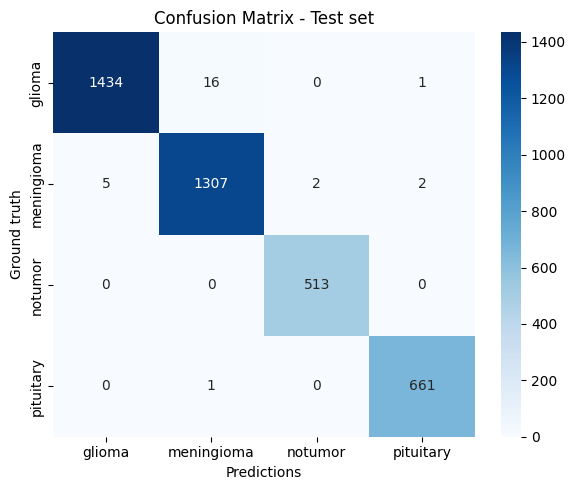

test/accuracy,▁
test/f1_macro,▁
test/glioma/f1,▁
test/glioma/precision,▁
test/glioma/recall,▁
test/meningioma/f1,▁
test/meningioma/precision,▁
test/meningioma/recall,▁
test/notumor/f1,▁
test/notumor/precision,▁
+7,...



Evaluation completed and logged to W&B


In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import os

# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="resnet50_sgd_evaluation",
    job_type="evaluation"
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)


# Load the trained model
model_path = "best_resnet50_sgd.pth"
assert os.path.exists(model_path), "Model not found!"

model_ft = resnet50(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft.load_state_dict(torch.load(model_path, map_location=device))
model_ft = model_ft.to(device)
model_ft.eval()

# Test Dataset & DataLoader
test_dir = "/content/dataset_local/test"

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

classes = test_dataset.classes
print("Classes:", classes)
print("Number of test images:", len(test_dataset))

# Evaluation loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

# ROC-AUC multiclass
y_true_bin = label_binarize(all_labels, classes=[0,1,2,3])
roc_auc_macro = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")

print("\n=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")

# W&B logging
wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})

# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })

# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Confusion Matrix - Test set")
plt.tight_layout()
plt.show()

# Save model as Artifact
artifact = wandb.Artifact(
    name="resnet50_sgd",
    type="model",
    description="ResNet50 sgd evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()
print("\nEvaluation completed and logged to W&B")


### VGG16 SGD


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os
import shutil
import numpy as np
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from tqdm.notebook import tqdm
import wandb
from collections import Counter


if 'local_path' in globals() and not os.path.exists(local_path):
    print("Copying the dataset to the local VM...")
    shutil.copytree(drive_path, local_path)
    print("Copy finished.")

# Configuration
physical_batch_size = 16
accumulation_steps = 2

config = {
    "batch_size_physical": physical_batch_size,
    "batch_size_effective": physical_batch_size * accumulation_steps,
    "lr": 1e-3,
    "momentum": 0.9,
    "epochs": 60,
    "architecture": "VGG16_BN",
    "strategy": "Fine-Tuning (Full Classifier) + Grad Accumulation",
    "optimizer": "SGD_Nesterov",
    "augmentation": "HorizontalFlip+Rotation"
}

wandb.login(key="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") # Pense à remettre ta clé si besoin
wandb.init(project="brain_tumor_classification", name="vgg16_sgd", config=config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Datasets & Dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(local_path, x), transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=physical_batch_size,
                             shuffle=True if x=='train' else False,
                             num_workers=2, pin_memory=True)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
classes = image_datasets['train'].classes

# Unbalanced weights
train_targets = image_datasets['train'].targets
count_dict = Counter(train_targets)
class_count = [count_dict[i] for i in range(len(classes))]
total_count = sum(class_count)
weights = [total_count / (len(classes) * c) for c in class_count]
class_weights = torch.FloatTensor(weights).to(device)
print(f"Weights : {weights}")


# VGG16 model
weights_model = VGG16_BN_Weights.DEFAULT
model_ft = vgg16_bn(weights=weights_model)

# Freeze Features
for param in model_ft.features.parameters():
    param.requires_grad = False

# Unfreeze Classifier
for param in model_ft.classifier.parameters():
    param.requires_grad = True

# Custom Head
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(model_ft.parameters(),
                      lr=config['lr'],
                      momentum=0.9,
                      weight_decay=1e-4,
                      nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


# Training loop
num_epochs = config['epochs']
patience = 8
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*20)

    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({"lr": current_lr, "epoch": epoch+1})

    for phase in ['train','val']:
        if phase=='train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        all_preds = []
        all_labels = []

        optimizer.zero_grad()

        loop = tqdm(dataloaders[phase], desc=f"{phase} Ep {epoch+1}", leave=False)

        for i, (inputs, labels) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(phase=='train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss = loss / accumulation_steps
                    loss.backward()

                    if (i + 1) % accumulation_steps == 0:
                        optimizer.step()
                        optimizer.zero_grad()

            batch_loss = loss.item() * accumulation_steps if phase == 'train' else loss.item()

            running_loss += batch_loss * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

            if phase == 'val':
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=batch_loss, acc=(torch.sum(preds==labels.data).double()/inputs.size(0)).item())

        if phase == 'train' and len(dataloaders['train']) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, "epoch": epoch+1})

        if phase=='val':
            scheduler.step(epoch_loss)

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())
                epochs_no_improve = 0

                torch.save(model_ft.state_dict(), "best_vgg16_sgd.pth")
                wandb.save("best_vgg16_sgd.pth")

                wandb.log({"conf_mat": wandb.plot.confusion_matrix(probs=None,
                                                       y_true=all_labels,
                                                       preds=all_preds,
                                                       class_names=classes)})

                print(f"--> New best (Acc: {best_acc:.4f})")
            else:
                epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), "final_vgg16_sgd.pth")
wandb.save("final_vgg16_sgd.pth")
wandb.finish()
print("Training complete.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING [wandb.login()] Changing session credentials to explicit value for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Device : cuda:0
Weights : [0.6791309488619568, 0.7484932399413585, 1.9242043551088777, 1.4885001619695497]
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:10<00:00, 54.8MB/s]



Epoch 1/60
--------------------


train Ep 1:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.4185 Acc: 0.8201


val Ep 1:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.2429 Acc: 0.9070


wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


--> New best (Acc: 0.9070)

Epoch 2/60
--------------------


train Ep 2:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.2647 Acc: 0.8854


val Ep 2:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.2167 Acc: 0.9177
--> New best (Acc: 0.9177)

Epoch 3/60
--------------------


train Ep 3:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.2052 Acc: 0.9085


val Ep 3:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.1731 Acc: 0.9357
--> New best (Acc: 0.9357)

Epoch 4/60
--------------------


train Ep 4:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.1769 Acc: 0.9222


val Ep 4:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.1450 Acc: 0.9479
--> New best (Acc: 0.9479)

Epoch 5/60
--------------------


train Ep 5:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.1576 Acc: 0.9310


val Ep 5:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.1383 Acc: 0.9512
--> New best (Acc: 0.9512)

Epoch 6/60
--------------------


train Ep 6:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.1416 Acc: 0.9378


val Ep 6:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.1197 Acc: 0.9568
--> New best (Acc: 0.9568)

Epoch 7/60
--------------------


train Ep 7:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.1230 Acc: 0.9459


val Ep 7:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.1062 Acc: 0.9649
--> New best (Acc: 0.9649)

Epoch 8/60
--------------------


train Ep 8:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.1083 Acc: 0.9504


val Ep 8:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.1005 Acc: 0.9627

Epoch 9/60
--------------------


train Ep 9:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0953 Acc: 0.9569


val Ep 9:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0891 Acc: 0.9693
--> New best (Acc: 0.9693)

Epoch 10/60
--------------------


train Ep 10:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0906 Acc: 0.9584


val Ep 10:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0845 Acc: 0.9715
--> New best (Acc: 0.9715)

Epoch 11/60
--------------------


train Ep 11:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0868 Acc: 0.9609


val Ep 11:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0762 Acc: 0.9748
--> New best (Acc: 0.9748)

Epoch 12/60
--------------------


train Ep 12:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0759 Acc: 0.9671


val Ep 12:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0693 Acc: 0.9787
--> New best (Acc: 0.9787)

Epoch 13/60
--------------------


train Ep 13:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0667 Acc: 0.9700


val Ep 13:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0645 Acc: 0.9794
--> New best (Acc: 0.9794)

Epoch 14/60
--------------------


train Ep 14:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0613 Acc: 0.9719


val Ep 14:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0631 Acc: 0.9794

Epoch 15/60
--------------------


train Ep 15:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0618 Acc: 0.9742


val Ep 15:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0592 Acc: 0.9804
--> New best (Acc: 0.9804)

Epoch 16/60
--------------------


train Ep 16:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0573 Acc: 0.9750


val Ep 16:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0546 Acc: 0.9832
--> New best (Acc: 0.9832)

Epoch 17/60
--------------------


train Ep 17:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0502 Acc: 0.9784


val Ep 17:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0498 Acc: 0.9850
--> New best (Acc: 0.9850)

Epoch 18/60
--------------------


train Ep 18:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0503 Acc: 0.9791


val Ep 18:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0523 Acc: 0.9827

Epoch 19/60
--------------------


train Ep 19:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0451 Acc: 0.9803


val Ep 19:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0463 Acc: 0.9865
--> New best (Acc: 0.9865)

Epoch 20/60
--------------------


train Ep 20:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0428 Acc: 0.9801


val Ep 20:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0437 Acc: 0.9876
--> New best (Acc: 0.9876)

Epoch 21/60
--------------------


train Ep 21:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0405 Acc: 0.9823


val Ep 21:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0402 Acc: 0.9878
--> New best (Acc: 0.9878)

Epoch 22/60
--------------------


train Ep 22:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0378 Acc: 0.9836


val Ep 22:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0358 Acc: 0.9906
--> New best (Acc: 0.9906)

Epoch 23/60
--------------------


train Ep 23:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0346 Acc: 0.9859


val Ep 23:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0369 Acc: 0.9896

Epoch 24/60
--------------------


train Ep 24:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0308 Acc: 0.9866


val Ep 24:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0364 Acc: 0.9893

Epoch 25/60
--------------------


train Ep 25:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0327 Acc: 0.9859


val Ep 25:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0356 Acc: 0.9916
--> New best (Acc: 0.9916)

Epoch 26/60
--------------------


train Ep 26:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0316 Acc: 0.9867


val Ep 26:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0366 Acc: 0.9901

Epoch 27/60
--------------------


train Ep 27:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0298 Acc: 0.9873


val Ep 27:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0353 Acc: 0.9888

Epoch 28/60
--------------------


train Ep 28:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0297 Acc: 0.9872


val Ep 28:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0333 Acc: 0.9926
--> New best (Acc: 0.9926)

Epoch 29/60
--------------------


train Ep 29:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0261 Acc: 0.9886


val Ep 29:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0356 Acc: 0.9906

Epoch 30/60
--------------------


train Ep 30:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0267 Acc: 0.9879


val Ep 30:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0340 Acc: 0.9909

Epoch 31/60
--------------------


train Ep 31:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0244 Acc: 0.9893


val Ep 31:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0304 Acc: 0.9911

Epoch 32/60
--------------------


train Ep 32:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0261 Acc: 0.9894


val Ep 32:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0283 Acc: 0.9931
--> New best (Acc: 0.9931)

Epoch 33/60
--------------------


train Ep 33:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0221 Acc: 0.9910


val Ep 33:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0296 Acc: 0.9924

Epoch 34/60
--------------------


train Ep 34:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0201 Acc: 0.9915


val Ep 34:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0277 Acc: 0.9931

Epoch 35/60
--------------------


train Ep 35:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0205 Acc: 0.9911


val Ep 35:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0296 Acc: 0.9924

Epoch 36/60
--------------------


train Ep 36:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0191 Acc: 0.9923


val Ep 36:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0288 Acc: 0.9931

Epoch 37/60
--------------------


train Ep 37:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0204 Acc: 0.9913


val Ep 37:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0269 Acc: 0.9947
--> New best (Acc: 0.9947)

Epoch 38/60
--------------------


train Ep 38:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0181 Acc: 0.9924


val Ep 38:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0275 Acc: 0.9931

Epoch 39/60
--------------------


train Ep 39:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0182 Acc: 0.9921


val Ep 39:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0285 Acc: 0.9931

Epoch 40/60
--------------------


train Ep 40:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0188 Acc: 0.9916


val Ep 40:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0272 Acc: 0.9926

Epoch 41/60
--------------------


train Ep 41:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 0.9927


val Ep 41:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0288 Acc: 0.9929

Epoch 42/60
--------------------


train Ep 42:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0167 Acc: 0.9925


val Ep 42:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0266 Acc: 0.9942

Epoch 43/60
--------------------


train Ep 43:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0168 Acc: 0.9931


val Ep 43:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0281 Acc: 0.9944

Epoch 44/60
--------------------


train Ep 44:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0142 Acc: 0.9935


val Ep 44:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0253 Acc: 0.9947

Epoch 45/60
--------------------


train Ep 45:   0%|          | 0/1149 [00:00<?, ?it/s]

train Loss: 0.0155 Acc: 0.9940


val Ep 45:   0%|          | 0/246 [00:00<?, ?it/s]

val Loss: 0.0239 Acc: 0.9947
Early stopping triggered


wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████
val_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,45
lr,0.001
train_acc,0.99402
train_loss,0.01546
val_acc,0.99466


Training complete.


#### Evaluation

Device used: cuda:0
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of test images: 3942

=== GLOBAL METRICS ===
Accuracy        : 0.9911
Precision macro : 0.9909
Recall macro    : 0.9925
F1-score macro  : 0.9917
ROC-AUC macro   : 0.9998

=== CLASS-WISE METRICS ===
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99      1451
  meningioma       0.99      0.99      0.99      1316
     notumor       1.00      0.99      1.00       513
   pituitary       0.98      1.00      0.99       662

    accuracy                           0.99      3942
   macro avg       0.99      0.99      0.99      3942
weighted avg       0.99      0.99      0.99      3942



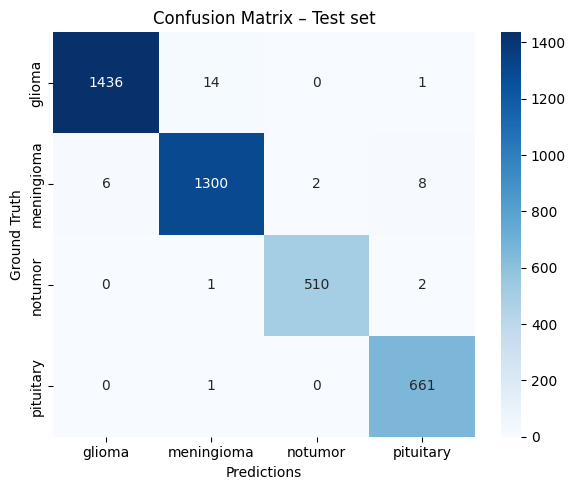

test/accuracy,▁
test/f1_macro,▁
test/glioma/f1,▁
test/glioma/precision,▁
test/glioma/recall,▁
test/meningioma/f1,▁
test/meningioma/precision,▁
test/meningioma/recall,▁
test/notumor/f1,▁
test/notumor/precision,▁
+7,...



Evaluation completed and logged to W&B


In [10]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import vgg16_bn, VGG16_BN_Weights

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# W&B Initialization
wandb.login()
wandb.init(
    project="brain_tumor_classification_test",
    name="vgg16_sgd_evaluation",
    job_type="evaluation"
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

# Load trained model
model_path = "best_vgg16_sgd.pth"
assert os.path.exists(model_path), "Model not found!"

weights_model = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights=None)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 4)

model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Test Dataset & DataLoader
test_dir = "/content/dataset_local/test"

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

classes = test_dataset.classes
print("Classes:", classes)
print("Number of test images:", len(test_dataset))


# Evaluation loop
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Global Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

# ROC-AUC multi-class
y_true_bin = label_binarize(all_labels, classes=list(range(len(classes))))
roc_auc_macro = roc_auc_score(
    y_true_bin,
    all_probs,
    average="macro",
    multi_class="ovr"
)

print("\n=== GLOBAL METRICS ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro    : {recall:.4f}")
print(f"F1-score macro  : {f1:.4f}")
print(f"ROC-AUC macro   : {roc_auc_macro:.4f}")

wandb.log({
    "test/accuracy": accuracy,
    "test/precision_macro": precision,
    "test/recall_macro": recall,
    "test/f1_macro": f1,
    "test/roc_auc_macro": roc_auc_macro
})

# Class-wise Metrics
report = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

print("\n=== CLASS-WISE METRICS ===")
print(classification_report(all_labels, all_preds, target_names=classes))

for cls in classes:
    wandb.log({
        f"test/{cls}/precision": report[cls]["precision"],
        f"test/{cls}/recall": report[cls]["recall"],
        f"test/{cls}/f1": report[cls]["f1-score"]
    })

# Confusion Matrix
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels,
        preds=all_preds,
        class_names=classes
    )
})

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix – Test set")
plt.tight_layout()
plt.show()


# Save model as Artifact
artifact = wandb.Artifact(
    name="vgg16_sgd",
    type="model",
    description="VGG16_BN evaluated on test set"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()
print("\nEvaluation completed and logged to W&B")
